Name: Elad Shoham

ID: 206001752

# Imports and Definitions

In [1]:
# import numpy, matplotlib, torch etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary

# sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Exploration

In [3]:
# load MNIST dataset
image_normalize = lambda x : x / 255

data_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=True, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                          transforms.Lambda(image_normalize)])),
                                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=False, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                          transforms.Lambda(image_normalize)])),
                                                          batch_size=50, 
                                                          shuffle=True)

**Split Data to Train and Validation**

In [4]:
# split the data into 50000 train and 10000 validation
train, validation = torch.utils.data.random_split(data_loader.dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=50, shuffle=False)

In [5]:
data_images = data_loader.dataset.data / 255
data_labels = data_loader.dataset.targets

train_images = torch.reshape(data_images[:50000], [len(data_images[:50000]), 1, 28, 28]).cpu()
train_labels = data_labels[:50000]

validation_images = torch.reshape(data_images[10000:], [len(data_images[10000:]), 1, 28, 28]).cpu()
validation_labels = data_labels[10000:]

test_images = test_loader.dataset.data / 255
test_images = torch.reshape(test_images, [len(test_images), 1, 28, 28]).cpu()
test_labels = test_loader.dataset.targets

In [6]:
# show image with title
def print_image(image, title):
  plt.title(title)
  plt.imshow(image)
  plt.show()

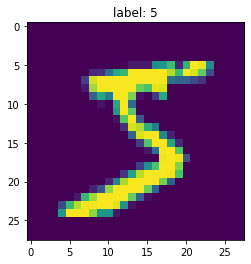

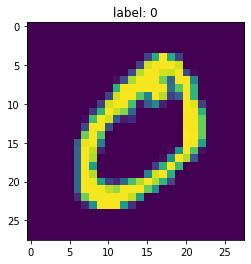

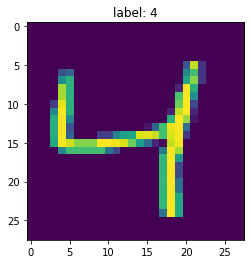

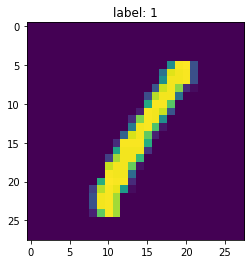

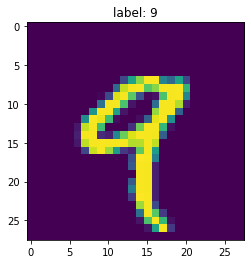

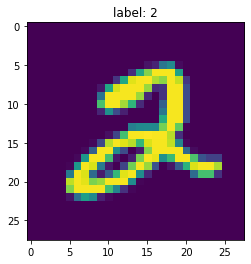

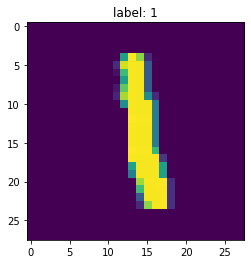

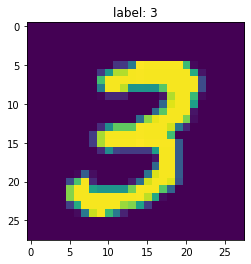

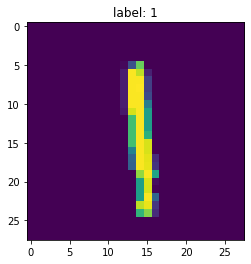

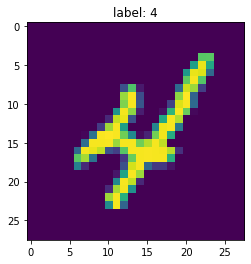

In [7]:
# display 10 images from the train dataset
images = 10

for i in range(images):
  print_image(train_images[i][0], 'label: ' + str(train_labels.float()[i])[-3:-2])

# Functions

In [8]:
# calculates the accuracy between the prediction and the targets
def accuracy(y, t):
  score, predicted = torch.max(y, 1)
  acc = (t == predicted).sum().float() / len(t)
  return acc

In [9]:
# predict data by model
def predict(model, data):
  y_softmax = model(data)
  score, y = torch.max(y_softmax, 1)
  return y

In [10]:
# calculate success metrics for each category
def score(y, t):
  targets = np.unique(data_labels)
  acc = accuracy_score(t, y)
  recall = recall_score(t, y, average=None, zero_division=1, labels=targets)
  precision = precision_score(t, y, average=None, zero_division=1, labels=targets)
  f1 = f1_score(t, y, average=None, zero_division=1, labels=targets)
  balanced_accuracy = balanced_accuracy_score(t, y)
  return acc, recall, precision, f1, balanced_accuracy

In [11]:
# evaluating the model on the data according to the mean of the success metrics
def evaluate(model, data):
  accuracies = []
  recalls = []
  precisions = []
  f1_scores = []
  balanced_accuracies = []

  for batch_idx, (images, labels) in enumerate(data):
    y = predict(model, images.to(device)).cpu()
    acc, recall, precision, f1, balanced_accuracy = score(y, labels)
    accuracies.append(acc)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_accuracy)
  return np.mean(accuracies), np.mean(recalls), np.mean(precisions), np.mean(f1_scores), np.mean(balanced_accuracies)

In [12]:
# evaluate the model on each of the sets
def evaluate_model(model):
  results = {
      'Train': evaluate(model, train_loader),
      'Validation': evaluate(model, validation_loader),
      'Test': evaluate(model, test_loader)
  }

  return pd.DataFrame(results, index=['Accuracy', 'Recall', 'Precision', 'F1 score', 'Balanced accuracy'])

In [13]:
# printing weights in model
def print_weights(model, layer, num_of_images=5):
  weights = model[layer].weight.cpu()
  filters = np.random.default_rng().choice(weights.shape[0], num_of_images, replace=False)

  for filter in filters:
    plt.title(f'Filter: {filter}')
    plt.imshow(weights[filter][0].data)
    plt.show()

In [14]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
      activation[name] = output.detach()
    return hook

def image_conv(model, batch, layer, channel, after_activation=False):
  model[layer].register_forward_hook(get_activation(layer))
  batch = torch.reshape(batch, (len(batch), 1, 28, 28))
  output = predict(model, batch)
  print_image(activation[layer][channel][0].cpu(), 'After activation' if after_activation else 'Before activation')

In [15]:
lr = 1e-3
num_epochs = 10

def train_model(model, data):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = torch.nn.CrossEntropyLoss()
  
  start = time.time()
  for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}:')
    for batch_idx, (images, labels) in enumerate(data):
      images, labels = images.to(device), labels.to(device)

      predictions = model(images)
      cross_entropy = loss(predictions, labels)
      if not (batch_idx % 100):
        print('CE: %.6f, ACC: %.3f' % (cross_entropy.item(),  accuracy(predictions, labels).item()))

      # zero gradients berfore running the backward pass
      optimizer.zero_grad()

      # backward pass to compute the gradient of loss
      # backprop + accumulate 
      cross_entropy.backward()

      # update params
      optimizer.step()

  end = time.time()
  print('----------------------------------------------------------------')
  print('Train time:', end - start)
  summary(model, (1, 28, 28))

In [16]:
def init_conv2d_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        m.weight = nn.Parameter(torch.abs(m.weight))
        m.bias.data.fill_(0.01)

# Architectures

**Architecture 1**

In [17]:
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=10) # 28*28 = 784
)

train_model(model1, train_loader)

Epoch: 1:
CE: 2.301567, ACC: 0.160
CE: 2.287015, ACC: 0.160
CE: 2.273319, ACC: 0.600
CE: 2.245658, ACC: 0.540
CE: 2.244467, ACC: 0.620
CE: 2.228354, ACC: 0.580
CE: 2.213638, ACC: 0.660
CE: 2.192840, ACC: 0.740
CE: 2.209400, ACC: 0.520
CE: 2.189384, ACC: 0.540
Epoch: 2:
CE: 2.170941, ACC: 0.620
CE: 2.144598, ACC: 0.740
CE: 2.134669, ACC: 0.720
CE: 2.140599, ACC: 0.680
CE: 2.107497, ACC: 0.780
CE: 2.101410, ACC: 0.700
CE: 2.062056, ACC: 0.740
CE: 2.102427, ACC: 0.660
CE: 2.069880, ACC: 0.720
CE: 2.069028, ACC: 0.600
Epoch: 3:
CE: 2.017737, ACC: 0.760
CE: 2.044677, ACC: 0.680
CE: 2.008433, ACC: 0.660
CE: 2.002430, ACC: 0.660
CE: 1.937476, ACC: 0.780
CE: 1.993173, ACC: 0.700
CE: 2.005291, ACC: 0.660
CE: 1.984404, ACC: 0.740
CE: 1.925901, ACC: 0.760
CE: 1.910164, ACC: 0.780
Epoch: 4:
CE: 1.946408, ACC: 0.660
CE: 1.936310, ACC: 0.660
CE: 1.923212, ACC: 0.680
CE: 1.933904, ACC: 0.660
CE: 1.958786, ACC: 0.560
CE: 1.877118, ACC: 0.680
CE: 1.861126, ACC: 0.680
CE: 1.884203, ACC: 0.720
CE: 1.8918

**Architecture 2**

In [18]:
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=10)
)

train_model(model2, train_loader)

Epoch: 1:
CE: 2.306344, ACC: 0.040
CE: 2.207964, ACC: 0.380
CE: 1.220528, ACC: 0.700
CE: 1.037625, ACC: 0.740
CE: 0.707263, ACC: 0.780
CE: 0.667957, ACC: 0.820
CE: 0.856639, ACC: 0.720
CE: 0.645923, ACC: 0.820
CE: 0.786005, ACC: 0.720
CE: 0.840770, ACC: 0.740
Epoch: 2:
CE: 0.524805, ACC: 0.880
CE: 0.547055, ACC: 0.820
CE: 0.746781, ACC: 0.760
CE: 0.739201, ACC: 0.760
CE: 0.361564, ACC: 0.900
CE: 0.521526, ACC: 0.800
CE: 0.276322, ACC: 0.880
CE: 0.590683, ACC: 0.840
CE: 0.513736, ACC: 0.880
CE: 0.399453, ACC: 0.820
Epoch: 3:
CE: 0.259919, ACC: 0.920
CE: 0.415715, ACC: 0.900
CE: 0.336237, ACC: 0.900
CE: 0.275213, ACC: 0.920
CE: 0.260564, ACC: 0.920
CE: 0.476716, ACC: 0.860
CE: 0.310863, ACC: 0.860
CE: 0.477106, ACC: 0.880
CE: 0.325713, ACC: 0.900
CE: 0.369663, ACC: 0.900
Epoch: 4:
CE: 0.277686, ACC: 0.920
CE: 0.404754, ACC: 0.880
CE: 0.253814, ACC: 0.940
CE: 0.395004, ACC: 0.900
CE: 0.461050, ACC: 0.820
CE: 0.363724, ACC: 0.900
CE: 0.480015, ACC: 0.840
CE: 0.299466, ACC: 0.920
CE: 0.3773

**Architecture 3**

In [19]:
model3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=64*7*7*2, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
  )

model3.apply(init_conv2d_weights)
train_model(model3, train_loader)

Epoch: 1:
CE: 2.298264, ACC: 0.180
CE: 1.517911, ACC: 0.660
CE: 0.798179, ACC: 0.720
CE: 0.538792, ACC: 0.780
CE: 0.602910, ACC: 0.860
CE: 0.689505, ACC: 0.720
CE: 0.288474, ACC: 0.880
CE: 0.505038, ACC: 0.840
CE: 0.326115, ACC: 0.900
CE: 0.285607, ACC: 0.880
Epoch: 2:
CE: 0.309382, ACC: 0.900
CE: 0.189652, ACC: 0.940
CE: 0.169129, ACC: 0.940
CE: 0.071711, ACC: 1.000
CE: 0.302075, ACC: 0.900
CE: 0.103648, ACC: 0.980
CE: 0.237977, ACC: 0.900
CE: 0.301392, ACC: 0.920
CE: 0.197721, ACC: 0.920
CE: 0.149416, ACC: 0.960
Epoch: 3:
CE: 0.258979, ACC: 0.940
CE: 0.349600, ACC: 0.920
CE: 0.257791, ACC: 0.920
CE: 0.280832, ACC: 0.920
CE: 0.167981, ACC: 0.960
CE: 0.114192, ACC: 0.960
CE: 0.186933, ACC: 0.940
CE: 0.109387, ACC: 0.940
CE: 0.177647, ACC: 0.960
CE: 0.164237, ACC: 0.940
Epoch: 4:
CE: 0.182523, ACC: 0.940
CE: 0.055631, ACC: 1.000
CE: 0.199061, ACC: 0.940
CE: 0.229863, ACC: 0.960
CE: 0.172823, ACC: 0.960
CE: 0.051022, ACC: 0.980
CE: 0.158790, ACC: 0.940
CE: 0.224260, ACC: 0.960
CE: 0.1696

**Architecture 4**

In [20]:
model4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
  )

model4.apply(init_conv2d_weights)
train_model(model4, train_loader)

Epoch: 1:
CE: 2.305370, ACC: 0.040
CE: 1.430034, ACC: 0.620
CE: 0.735415, ACC: 0.760
CE: 0.448766, ACC: 0.880
CE: 0.299126, ACC: 0.840
CE: 0.507082, ACC: 0.860
CE: 0.422678, ACC: 0.880
CE: 0.535212, ACC: 0.820
CE: 0.233604, ACC: 0.960
CE: 0.304584, ACC: 0.880
Epoch: 2:
CE: 0.454705, ACC: 0.920
CE: 0.253400, ACC: 0.900
CE: 0.090569, ACC: 0.960
CE: 0.136441, ACC: 0.960
CE: 0.394863, ACC: 0.880
CE: 0.114988, ACC: 0.960
CE: 0.219509, ACC: 0.940
CE: 0.121572, ACC: 0.960
CE: 0.094248, ACC: 0.960
CE: 0.163352, ACC: 0.920
Epoch: 3:
CE: 0.107211, ACC: 0.980
CE: 0.023860, ACC: 1.000
CE: 0.186388, ACC: 0.980
CE: 0.100990, ACC: 0.960
CE: 0.128070, ACC: 0.940
CE: 0.028246, ACC: 1.000
CE: 0.053968, ACC: 0.980
CE: 0.067212, ACC: 0.980
CE: 0.189594, ACC: 0.880
CE: 0.016483, ACC: 1.000
Epoch: 4:
CE: 0.095541, ACC: 0.980
CE: 0.110174, ACC: 0.980
CE: 0.120308, ACC: 0.940
CE: 0.182881, ACC: 0.900
CE: 0.010236, ACC: 1.000
CE: 0.029223, ACC: 0.980
CE: 0.053098, ACC: 0.980
CE: 0.037486, ACC: 0.980
CE: 0.0854

**Architecture 5 (batch_size=50)**

In [21]:
dropout_rate = 0.5
model5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
  )

model5.apply(init_conv2d_weights)
train_model(model5, train_loader)

Epoch: 1:
CE: 2.299979, ACC: 0.100
CE: 1.867663, ACC: 0.520
CE: 0.967789, ACC: 0.720
CE: 0.562664, ACC: 0.800
CE: 0.457442, ACC: 0.900
CE: 0.440737, ACC: 0.860
CE: 0.297802, ACC: 0.880
CE: 0.493349, ACC: 0.880
CE: 0.413713, ACC: 0.880
CE: 0.316653, ACC: 0.900
Epoch: 2:
CE: 0.237688, ACC: 0.860
CE: 0.191726, ACC: 0.960
CE: 0.257994, ACC: 0.900
CE: 0.128836, ACC: 0.960
CE: 0.108642, ACC: 0.960
CE: 0.288480, ACC: 0.900
CE: 0.137236, ACC: 0.960
CE: 0.101770, ACC: 0.980
CE: 0.170134, ACC: 0.900
CE: 0.128940, ACC: 0.960
Epoch: 3:
CE: 0.184937, ACC: 0.900
CE: 0.123646, ACC: 0.960
CE: 0.084679, ACC: 0.960
CE: 0.106808, ACC: 0.980
CE: 0.141648, ACC: 0.980
CE: 0.105044, ACC: 0.960
CE: 0.158201, ACC: 0.960
CE: 0.117584, ACC: 0.940
CE: 0.236681, ACC: 0.940
CE: 0.121915, ACC: 0.960
Epoch: 4:
CE: 0.043557, ACC: 0.980
CE: 0.074788, ACC: 0.980
CE: 0.057101, ACC: 1.000
CE: 0.051346, ACC: 1.000
CE: 0.049214, ACC: 0.980
CE: 0.053831, ACC: 0.980
CE: 0.205049, ACC: 0.980
CE: 0.074306, ACC: 0.980
CE: 0.3287

**Architecture 5 (batch_size=100)**

In [22]:
# set train data to batch_size = 100
train_loader_100 = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

In [23]:
dropout_rate = 0.5
model5_a = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
  )

model5_a.apply(init_conv2d_weights)
train_model(model5_a, train_loader_100)

Epoch: 1:
CE: 2.301015, ACC: 0.110
CE: 2.008911, ACC: 0.400
CE: 0.618600, ACC: 0.780
CE: 0.610082, ACC: 0.820
CE: 0.474160, ACC: 0.870
Epoch: 2:
CE: 0.354602, ACC: 0.870
CE: 0.376928, ACC: 0.870
CE: 0.188809, ACC: 0.930
CE: 0.324046, ACC: 0.900
CE: 0.170637, ACC: 0.940
Epoch: 3:
CE: 0.123609, ACC: 0.960
CE: 0.184714, ACC: 0.960
CE: 0.194864, ACC: 0.960
CE: 0.151471, ACC: 0.960
CE: 0.129583, ACC: 0.960
Epoch: 4:
CE: 0.140680, ACC: 0.940
CE: 0.164268, ACC: 0.960
CE: 0.082895, ACC: 0.970
CE: 0.045072, ACC: 0.990
CE: 0.108565, ACC: 0.950
Epoch: 5:
CE: 0.077027, ACC: 0.980
CE: 0.083645, ACC: 0.960
CE: 0.118210, ACC: 0.990
CE: 0.050836, ACC: 0.990
CE: 0.088927, ACC: 0.960
Epoch: 6:
CE: 0.121198, ACC: 0.960
CE: 0.061459, ACC: 0.990
CE: 0.165863, ACC: 0.920
CE: 0.128423, ACC: 0.960
CE: 0.034599, ACC: 0.990
Epoch: 7:
CE: 0.148651, ACC: 0.950
CE: 0.048442, ACC: 0.980
CE: 0.062252, ACC: 0.980
CE: 0.065674, ACC: 0.980
CE: 0.116197, ACC: 0.980
Epoch: 8:
CE: 0.108222, ACC: 0.980
CE: 0.037613, ACC: 1

It can be seen from the training that the model with batch_size = 50 reached a balance accuracy of 0.99 at the beginning of epoch 4, and the model with batch_size = 100 reached a balance accuracy of 0.99 at the end of epoch 4.



# Evaluating the results

**Architecture 1**

In [25]:
evaluate_model(model1)

,Train,Validation,Test
Accuracy,0.798160,0.799200,0.813500
Recall,0.796545,0.790014,0.809836
Precision,0.818530,0.815939,0.830611
F1 score,0.772509,0.769516,0.788976
Balanced accuracy,0.795518,0.788838,0.809334


**Architecture 2**

In [26]:
evaluate_model(model2)

,Train,Validation,Test
Accuracy,0.943020,0.934700,0.938900
Recall,0.942800,0.933755,0.939754
Precision,0.944436,0.934043,0.940551
F1 score,0.935066,0.923071,0.931377
Balanced accuracy,0.942468,0.933375,0.939454


**Architecture 3**

In [27]:
evaluate_model(model3)

,Train,Validation,Test
Accuracy,0.981060,0.973200,0.974700
Recall,0.980832,0.972554,0.973685
Precision,0.981670,0.973274,0.975110
F1 score,0.978122,0.967956,0.969806
Balanced accuracy,0.980741,0.972397,0.973552


**Architecture 4**

In [28]:
evaluate_model(model4)

,Train,Validation,Test
Accuracy,0.991780,0.983100,0.984100
Recall,0.992043,0.982843,0.983758
Precision,0.992369,0.983004,0.984837
F1 score,0.991067,0.980142,0.981711
Balanced accuracy,0.991997,0.982745,0.983758


**Architecture 5 (batch_size=50)**

In [29]:
evaluate_model(model5)

,Train,Validation,Test
Accuracy,0.987360,0.980100,0.981200
Recall,0.987467,0.978323,0.980666
Precision,0.987718,0.979579,0.980089
F1 score,0.985707,0.975441,0.976403
Balanced accuracy,0.987405,0.978204,0.980525


**Architecture 5 (batch_size=100)**

In [30]:
evaluate_model(model5_a)

,Train,Validation,Test
Accuracy,0.981120,0.971900,0.976300
Recall,0.981198,0.970971,0.975864
Precision,0.981544,0.972618,0.976055
F1 score,0.978123,0.966097,0.971601
Balanced accuracy,0.981099,0.970784,0.975743


# Best Model Visualizations

We can see from the success metrics that model 4 had the highest balance accuracy of all the convolution layers and therefore we can choose this model to display his weights and convolution images.

**5 Different Visualizations**

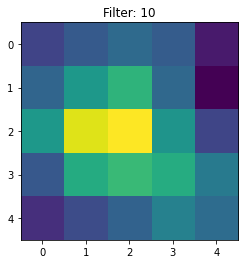

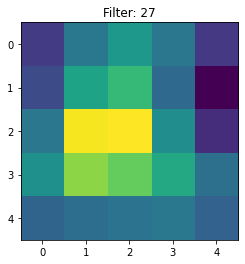

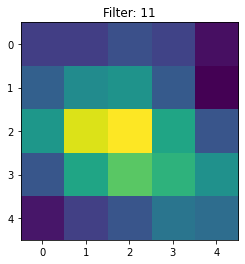

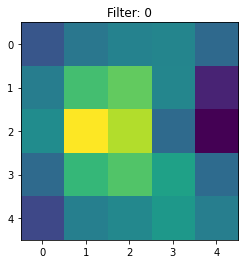

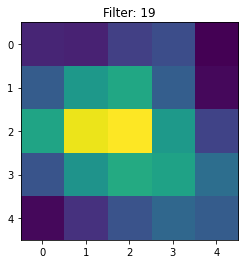

In [31]:
print_weights(model4, 0, num_of_images=5)

**4 Images of the Convolution**

First Layer:


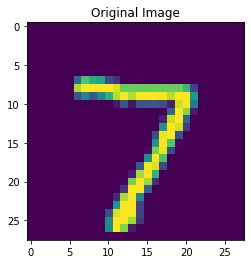

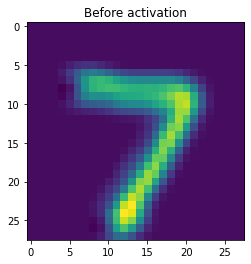

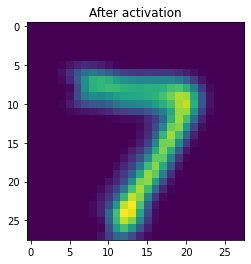

----------------------------------------------------------------
Second Layer:


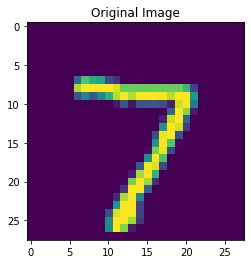

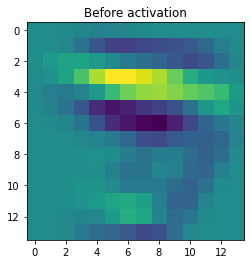

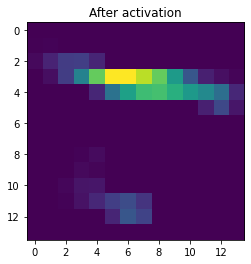

In [32]:
channel = np.random.randint(32)
print('First Layer:')
print_image(test_images[channel][0], 'Original Image')
image_conv(model4, batch=test_images.to(device), layer=0, channel=channel, after_activation=False)
image_conv(model4, batch=test_images.to(device), layer=1, channel=channel, after_activation=True)

print('----------------------------------------------------------------')

channel = np.random.randint(32)
print('Second Layer:')
print_image(test_images[channel][0], 'Original Image')
image_conv(model4, batch=test_images.to(device), layer=3, channel=channel, after_activation=False)
image_conv(model4, batch=test_images.to(device), layer=4, channel=channel, after_activation=True)